#  James O'Rourke 15334121 Case Studies Assignment

In [1]:
#All the imports I need
import numpy as np 
import cv2 ,time, random
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers
import pandas as pd
import matplotlib.pyplot as plt
from keras.layers.core import Dense, Activation
from keras.optimizers import Adam
from keras.layers import Dense,GlobalAveragePooling2D
from keras.applications import MobileNet
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras.preprocessing
from IPython.display import display
from PIL import Image
%matplotlib inline

In [2]:
#Function that will return an F1 score for ever frame in term of a list
#Will caculate f1 for every frame by first calculating precsion and accuracy for each frame

def F1ScoreCalc(preds,truth):
    F1Scores = []

    for k in range(0, len(truth)-1):
        if preds[k] == truth[k]:#When real = predicted
            recall, precision = 1, 1
        elif preds[k] > truth[k]: #When prediction > truth
            TP = truth[k]
            FP = (preds[k] - truth[k])
            recall, precision = 1, TP/(TP+FP)
        else:                     #When prediction < truth
            TP = preds[k]
            FN = truth[k] - preds[k]
            recall, precision = (TP/(TP+FN)), 1
        #Calculate the F1 score

        F1 = 2*((recall*precision)/(recall+precision))
        F1Scores.append(F1)
        
    return F1Scores

#Also reading the groundtruth file preparing list of results to compare to
groundTruth = pd.read_excel("Groundtruth.xlsx")

TrueCarCount = groundTruth.loc[:,"Total"].tolist()

TrueSUVCount = groundTruth.loc[:,"SUV"].tolist()

TrueSedanCount = groundTruth.loc[:,"Sedan"].tolist()


Loading the the YoloV3-Tiny model into OpenCV using readNetFromDarknet. This will allow us to use darknet and obtaining the ROI which we can then pass into our classifer. Code based on https://www.learnpythonwithrune.org/how-to-get-started-with-yolo-in-python/


In [3]:


# Read labels that are used on object
labels = open("darknet/data/coco.names").read().splitlines()


# Give the configuration and weight files for the model and load the network
#Using tiny yolo v3 for cfg and weights
net = cv2.dnn.readNetFromDarknet("darknet/cfg/yolov3-tiny.cfg", "yolov3-tiny.weights")
# Determine the output layer,
ln = net.getLayerNames()
ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]



In [4]:
#List for containg number of cars per frame
car_count = []
#Storing times for analyis
yolo_times = []

#Pick a random frame to show
randFrame = random.randint(0,899)



#Cap is the video reader
cap = cv2.VideoCapture("assignment-clip.mp4")
currentFrame = 0


while(cap.isOpened()):
    ret, frame = cap.read()
    if ret == False:
        print("It stopped at frame ", currentFrame)
        break
    image = frame
    #Start the timer
    start = time.time()
    # Get the shape
    h, w = image.shape[:2]
    # Load it as a blob and feed it to the network
    blob = cv2.dnn.blobFromImage(image, 1 / 255.0, (416, 416), swapRB=True)
    net.setInput(blob)
    # Get the output
    layer_outputs = net.forward(ln)


    # Initialize the lists we need to interpret the results
    boxes = []
    confidences = []
    class_ids = []

    # Loop over the layers
    for output in layer_outputs:
        # For the layer loop over all detections
        for detection in output:
            # The detection first 4 entries contains the object position and size
            scores = detection[5:]
            # Then it has detection scores - it takes the one with maximal score
            class_id = np.argmax(scores).item()
            # The maximal score is the confidence
            confidence = scores[class_id].item()

            # Ensure we have some reasonable confidence in our prediction and only take class_id of 2 i.e. cars
            if confidence > 0.3 and class_id == 2:
                # The first four entries have the location and size (center, size)
                # It needs to be scaled up as the result is given in relative size (0.0 to 1.0)
                box = detection[0:4] * np.array([w, h, w, h])
                center_x, center_y, width, height = box.astype(int).tolist()
                
                
                #If my boudrey box is too small I want to make it a bit bigger
                if width*height < 3000:
                    width = width+width
                    height = height+height
                elif width*height < 6000:
                    width = width+width//2
                    height = height+height//2
                    
                
                
            
                # Calculate the upper corner
                x = center_x - width//2
                y = center_y - height//2
                
                
                # Add our findings to the lists
                boxes.append([x, y, width, height])
                confidences.append(confidence)
                class_ids.append(class_id)

    # Only keep the best boxes of the overlapping ones
    idxs = cv2.dnn.NMSBoxes(boxes, confidences,0.3, 0.4)
    
    #Take out count here
    car_count.append(len(idxs))
    # Ensure at least one detection exists - needed otherwise flatten will fail
    if len(idxs) > 0:
        # Loop over the indexes we are keeping
        for i in idxs.flatten():
            # Get the box information
            x, y, w, h = boxes[i]
            # Make a rectangle
            cv2.rectangle(image, (x, y), (x + w, y + h), (255,0,255), 2)
            # Make and add text
            text = "{}".format(labels[class_ids[i]])
            cv2.putText(image, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX,
                    0.5, (255,0,255), 1)
    
    #dispaly the random text image
    if currentFrame == randFrame:
        print("Displaying frame ",randFrame+1)
        cv2.imshow("Yolo Test image", image)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
    
    #Storing the procssed image
    cv2.imwrite("yoloFrames/img"+str(currentFrame)+".jpg",image)
    #End the end timer and add the time to our list
    end = time.time() 
    yolo_times.append(end - start)
    
    #update Frame count
    currentFrame += 1

    

#release the video reader
cap.release()
cv2.destroyAllWindows()


#Througput and execution time for the query
print("Total time taken to run tiny yolo on 900 images was",round(sum(yolo_times),3),"seconds")
print("With an average time per frame of ",round(np.mean(yolo_times),3))
print("Our overall F1 score for query 1 is ",round(np.mean(F1ScoreCalc(car_count,TrueCarCount)),4))

It stopped at frame  900
Total time taken to run tiny yolo on 900 images was 122.173 seconds
With an average time per frame of  0.136
Our overall F1 score for query 1 is  0.88


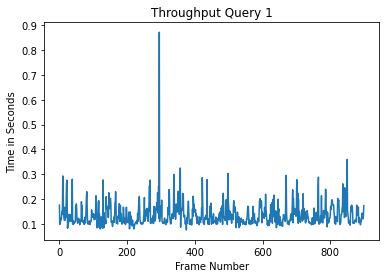

In [5]:
plt.plot(yolo_times)
plt.title('Throughput Query 1')
plt.ylabel('Time in Seconds')
plt.xlabel('Frame Number')
plt.show()

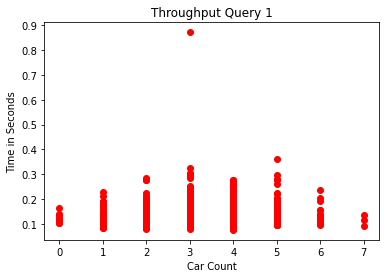

In [6]:
plt.plot(car_count,yolo_times,"ro")
plt.title('Throughput Query 1')
plt.ylabel('Time in Seconds')
plt.xlabel('Car Count')
plt.show()

# Loading datasets for training our keras model

I downloaded all my images using the chrome extension Image Downloader. I downloaded approximately 500 images of both Sedan and SUV cars with a little bit extra accounting for that I would have to remove some. I then went toughgh and manually took out any that I thought would contaminate my training progress.

Since I was using a ImageDataGenerator I split them into Training and Validation folders with a ratio of about 0.80 to training. I then further split these into folders labelled sedan and SUV.

In [ ]:
#Load model if want to skip training
model = keras.models.load_model('myKerasModel')


In [7]:

#Resizes image and adds a dimsesion of 1. THis helps when it comes to input shape of the keras model.
def prep_image(img):
    img = cv2.resize(img,(224,224))
    img_expanded = np.expand_dims(img, axis=0)
    return img_expanded

In [8]:
#Here I define my ImageDataGenerators. This allows me to augment my image data at random in batches for evrery epoch
#I done this to avoid overfitting. I did't perform any augmenation of the validation data.
#I used the prep_image function I defined earlier 

trainDataGen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function = prep_image,
                                                       rotation_range = 30,
                                                       horizontal_flip=True,
                                                       width_shift_range=0.05, 
                                                       height_shift_range=0.05,
                                                       shear_range=0.05,
                                                       zoom_range=0.05)



valDataGen = tf.keras.preprocessing.image.ImageDataGenerator(
                                   preprocessing_function = prep_image)



#Defines my training data which will be generated with ImageDataGenerator with augmentation at training time

train_images =  trainDataGen.flow_from_directory(
                                directory= "car_flow_data/train",
                                target_size=(224,224),
                                color_mode="rgb",
                                batch_size=32,
                                shuffle=True,
                                seed=127
                            )

#Does the same with my validation data minues the augmentation 
val_images = valDataGen.flow_from_directory(
                                "car_flow_data/valid",
                                color_mode='rgb', 
                                batch_size=32, 
                                target_size=(224,224), 
                                seed = 127,
                                shuffle=True
                            )



Found 804 images belonging to 2 classes.
Found 158 images belonging to 2 classes.


In [9]:
# A quick check to see the classes are correctly present in the data 
pred_names = train_images.class_indices
pred_names

{'sedan': 0, 'suv': 1}

# Making our Classification Model

In [23]:
#Loading the mobileNetV2 as our base model, weights from imagent and dont include top
base_model = tf.keras.applications.MobileNetV2(input_shape = (224,224,3), include_top=False, 
                                                weights = "imagenet")
#Freezing Weights in the base model
base_model.trainable = False


inputs = keras.Input(shape=(224,224,3))#My input layer



x = layers.GaussianNoise(stddev=0.5)(inputs)#Add some augmentation to images to avoid overfitting


x = tf.keras.applications.mobilenet.preprocess_input(x)#The mobile net fucntion to normalise the input



x= base_model(x, training=False)#The base mobile net model with frozen weights

x=GlobalAveragePooling2D()(x)

x=keras.layers.Dropout(0.4)(x)

x=Dense(1024,activation='relu')(x) 

x=keras.layers.Dropout(0.4)(x)

x=Dense(1024,activation='relu')(x) #we add dense layers so that the model 

x=keras.layers.Dropout(0.4)(x)

x=Dense(512,activation='relu')(x)

preds=Dense(2,activation='softmax')(x) #final layer with softmax activationn

In [24]:
#Defining my model and getting a summmary of all the layers
model=Model(inputs = inputs,outputs=preds)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
gaussian_noise_1 (GaussianNo (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.truediv_1 (TFOpLambd (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract_1 (TFOpLamb (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 1280)              0   

In [25]:
model.compile(optimizer='Adam',
               loss='categorical_crossentropy',
               metrics=['accuracy'])

#Will be training for 20 epochs
epoch = 20

# Training my model 

In [26]:
#Start training my model and time it.

start = time.time()
history = model.fit(train_images, epochs=epoch,validation_data = val_images,verbose=1)
end = time.time()

Epoch 1/20
26/26 [==============================] - 56s 2s/step - loss: 1.1489 - accuracy: 0.5770 - val_loss: 0.6083 - val_accuracy: 0.6392
Epoch 2/20
26/26 [==============================] - 43s 2s/step - loss: 0.5309 - accuracy: 0.7474 - val_loss: 0.6903 - val_accuracy: 0.7278
Epoch 3/20
26/26 [==============================] - 41s 2s/step - loss: 0.4661 - accuracy: 0.8020 - val_loss: 0.4392 - val_accuracy: 0.7785
Epoch 4/20
26/26 [==============================] - 38s 1s/step - loss: 0.3767 - accuracy: 0.8366 - val_loss: 0.4173 - val_accuracy: 0.8038
Epoch 5/20
26/26 [==============================] - 42s 2s/step - loss: 0.3400 - accuracy: 0.8568 - val_loss: 0.3442 - val_accuracy: 0.8544
Epoch 6/20
26/26 [==============================] - 43s 2s/step - loss: 0.3823 - accuracy: 0.8384 - val_loss: 0.4477 - val_accuracy: 0.7722
Epoch 7/20
26/26 [==============================] - 42s 2s/step - loss: 0.2966 - accuracy: 0.8749 - val_loss: 0.4332 - val_accuracy: 0.7848
Epoch 8/20
26/26 [==

Training time was  837 seconds


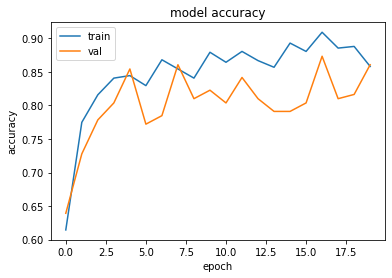

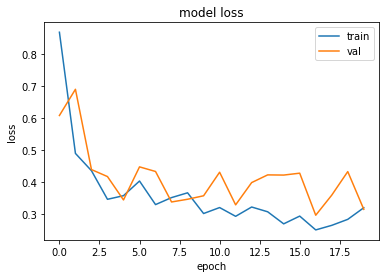

In [27]:
print("Training time was ",int(end - start), "seconds")


#Plot the accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


#Plot the loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [28]:
#Two test images I have just to make some quick evaluations on how my taining is going

src = cv2.imread("sedan.jpg")
img = prep_image(src)

pred = model.predict(img)
print(pred)

src = cv2.imread("suv.jpg")
img = prep_image(src)

pred = model.predict(img)
print(pred)

[[0.99030286 0.00969712]]
[[0.20285527 0.7971447 ]]


In [29]:
# Fine tuning with a very low learning rate

#Making sure the weights in the base model are unfrozen
base_model.trainable = True


model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
#Low epoch as we dont't want to over fit
epochs = 5
fineTuningHistory = model.fit(train_images, epochs=epochs, validation_data=val_images)

Epoch 1/5
26/26 [==============================] - 164s 6s/step - loss: 0.2810 - accuracy: 0.8768 - val_loss: 0.2900 - val_accuracy: 0.8734
Epoch 2/5
26/26 [==============================] - 159s 6s/step - loss: 0.2243 - accuracy: 0.8929 - val_loss: 0.3180 - val_accuracy: 0.8797
Epoch 3/5
26/26 [==============================] - 153s 6s/step - loss: 0.1982 - accuracy: 0.9226 - val_loss: 0.2506 - val_accuracy: 0.8987
Epoch 4/5
26/26 [==============================] - 149s 6s/step - loss: 0.1948 - accuracy: 0.9065 - val_loss: 0.2684 - val_accuracy: 0.8987
Epoch 5/5
26/26 [==============================] - 188s 7s/step - loss: 0.1581 - accuracy: 0.9351 - val_loss: 0.2445 - val_accuracy: 0.9114


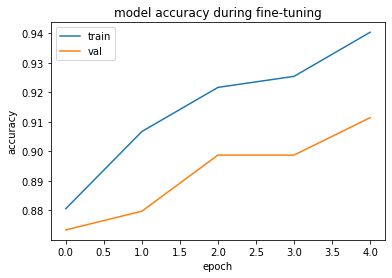

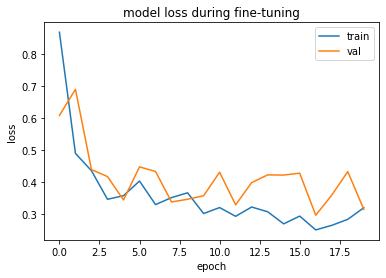

In [30]:

plt.plot(fineTuningHistory.history['accuracy'])
plt.plot(fineTuningHistory.history['val_accuracy'])
plt.title('model accuracy during fine-tuning')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss during fine-tuning')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [31]:
#Some quick test images I use 
src = cv2.imread("suv.jpg")
img = prep_image(src)

pred = model.predict(img)
print(pred)

src = cv2.imread("sedan.jpg")
img = prep_image(src)

pred = model.predict(img)
print(pred)


[[0.1823209  0.81767905]]
[[9.992655e-01 7.345582e-04]]


In [32]:
#List for containg number of cars per frame
car_count = []
suv_count = []
sedan_count = []
#Storing times for analyis
classify_times = []

frameSize = (428, 576)

#For out putting the video
out = cv2.VideoWriter('output_video.mp4',cv2.VideoWriter_fourcc(*'mp4v'), 30, frameSize)


#For Reading the video
cap = cv2.VideoCapture("assignment-clip.mp4")
currentFrame = 0



#Pick a random frame to show
randFrame = random.randint(0,899)



while(cap.isOpened()):
    ret, frame = cap.read()
    if ret == False:
        print("It stopped at frame ", currentFrame)
        break
    image = frame
    #Start the timer
    start = time.time()
    # Get the shape
    h, w = image.shape[:2]
    # Load it as a blob and feed it to the network
    blob = cv2.dnn.blobFromImage(image, 1 / 255.0, (416, 416), swapRB=True)
    net.setInput(blob)
    # Get the output
    layer_outputs = net.forward(ln)


    # Initialize the lists we need to interpret the results
    boxes = []
    confidences = []
    class_ids = []
    
    #The current amount of sedans/SUVs in the current frame
    current_sedan = 0
    current_suv = 0
    

    # Loop over the layers
    for output in layer_outputs:
        # For the layer loop over all detections
        for detection in output:
            # The detection first 4 entries contains the object position and size
            scores = detection[5:]
            # Then it has detection scores - it takes the one with maximal score
            class_id = np.argmax(scores).item()
            # The maximal score is the confidence
            confidence = scores[class_id].item()

            # Ensure we have some reasonable confidence in our prediction and only take class_id of 2 i.e. cars
            if confidence > 0.3 and class_id == 2:
                # The first four entries have the location and size (center, size)
                # It needs to be scaled up as the result is given in relative size (0.0 to 1.0)
                box = detection[0:4] * np.array([w, h, w, h])
                center_x, center_y, width, height = box.astype(int).tolist()
                
                
                #If my boudry box is too small I want to make it a bit bigger
                if width*height < 4000:
                    width = width+width
                    height = height+height
                elif width*height < 7000:
                    width = width+width//2
                    height = height+height//2
                    
                
            
                # Calculate the upper corner
                x = center_x - width//2
                y = center_y - height//2
                
                
        
                
                # Add our findings to the lists
                boxes.append([x, y, width, height])
                confidences.append(confidence)
                class_ids.append(class_id)

    # Only keep the best boxes of the overlapping ones
    idxs = cv2.dnn.NMSBoxes(boxes, confidences,0.3, 0.4)
    
    #Take out count here
    car_count.append(len(idxs))
    # Ensure at least one detection exists - needed otherwise flatten will fail
    if len(idxs) > 0:
        # Loop over the indexes we are keeping
        for i in idxs.flatten():
            # Get the box information
            x, y, w, h = boxes[i]
            #Classify each box here
            
            
            cropped = image[x:x+w, y:y+h]
            
            #Just to avoid any mistakes in cropping,bad crop will cause an error
            if cropped.size != 0:
                
            

                pre = prep_image(cropped)

                pred = model.predict(pre)

                
               
                
                
                #Assign labels based on the prediction
                #And update relevant count
                if np.argmax(pred) == 0:
                    current_sedan += 1
                    pred_label = "sedan"
                elif np.argmax(pred) == 1:
                    current_suv += 1
                    pred_label = "suv"
 


                # Make a rectangle
                cv2.rectangle(image, (x, y), (x + w, y + h), (255,0,255), 2)
                # add text
                cv2.putText(image, pred_label, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX,
                        1.3, (255, 255, 0), 1)
                
    #Append the car count the their lists       
    sedan_count.append(current_sedan)
    suv_count.append(current_suv)
    
    #Preparing text  images
    ResultText = "Car Count: "+str(car_count[currentFrame])
    SedanText = "Sedan Count: "+str(sedan_count[currentFrame])
    SUVText = "SUV Count: "+str(suv_count[currentFrame])
                                   
    cv2.putText(image,ResultText,(20,30),cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0,0,0), 2)
    cv2.putText(image,SedanText,(20,55),cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0,0,0), 2) 
    cv2.putText(image,SUVText,(20,85),cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0,0,0), 2)
                                   
    
    #if currentFrame == randFrame:
        print("Displaying frame ",randFrame+1)
        cv2.imshow("Classifer Test Image", image)
        cv2.waitKey(0)
        cv2.destroyAllWindows()

    
    #End the end timer and add the time to our list
    end = time.time() 
    classify_times.append(end - start)
    
    currentFrame += 1
    
    #Save the altered frame 
    cv2.imwrite("processedFrames/img"+str(currentFrame)+".jpg",image)
    #Send the altered image to the videoWriter
    out.write(image)

    

#release the video reader and the video writer
cap.release()
cv2.destroyAllWindows()
out.release()



print("Total time taken to run  on 900 images was",round(sum(classify_times),3),"seconds")
print("With an average time per frame of ",round(np.mean(classify_times),3))
print("Our overall F1 score for car detector  is ",round(np.mean(F1ScoreCalc(car_count,TrueCarCount)),4))
print("Our overall F1 score for suvs classified is ",round(np.mean(F1ScoreCalc(suv_count,TrueSUVCount)),4))
print("Our overall F1 score for sedans classified is ",round(np.mean(F1ScoreCalc(sedan_count,TrueSedanCount)),4))

It stopped at frame  900
Total time taken to run  on 900 images was 434.88 seconds
With an average time per frame of  0.483
Our overall F1 score for car detector  is  0.8857
Our overall F1 score for suvs classified is  0.6029
Our overall F1 score for sedans classified is  0.5815


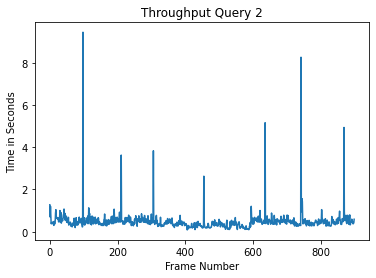

In [33]:
plt.plot(classify_times)
plt.title('Throughput Query 2')
plt.ylabel('Time in Seconds')
plt.xlabel('Frame Number')
plt.show()



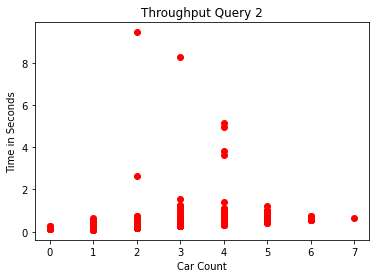

In [34]:
plt.plot(car_count,classify_times,"ro")
plt.title('Throughput Query 2')
plt.ylabel('Time in Seconds')
plt.xlabel('Car Count')
plt.show()

In [35]:
#Saving the model 
model.save('myKerasModel')

INFO:tensorflow:Assets written to: myKerasModel\assets


In [36]:
#Writing my results to a dataframe then to a excel file

frame_numbers = list(range(1,900))

resultDF = pd.DataFrame([frame_numbers,suv_count,sedan_count,car_count])

resultDF = resultDF.T

resultDF.columns = ["Frame Number","SUV Count", "Sedan Count", "Car Count"]

resultDF.head()

resultDF.to_excel("PipelineResults.xlsx") 